In [1]:
import json 
import numpy as np 
import pandas as pd
import plotly.express as px
import pdb
b = pdb.set_trace
class MyException(Exception):
    pass

In [2]:
# Helper functions.
state_df = pd.read_json('../public/radvizData/caDem.json')

get_score_from_choice_df = lambda t: t.values[0][1]

def create_sorted_attribute_df(original_df, attribute):
    return original_df.sort_values(attribute, ignore_index=True)[["county_name", attribute]]

def apply_func(df, func, state):
    res = df.copy(deep=True)
    for q in questions:
        ques = q["q"]
        base = get_cached_df(state, q['attr'])
        
        if q["target"] == "max":
            target = base.tail(1).values[0][0]
        elif q["target"] == "min":
            target = base.head(1).values[0][0]
        res[ques] = df[ques].apply(lambda x: func(base, x, target))
    return res

def get_cached_df(state, attr):
    if attr not in cached_state_attribute_df[state].keys():
        df = pd.read_json(metadata[state]["state_data"])
        cached_state_attribute_df[state][attr] = create_sorted_attribute_df(df, attr)
        
    return cached_state_attribute_df[state][attr]

In [3]:
def get_accuracy(choice_df, selected, target):

    """
    Given all possible answers tuples, the choosen answer, and the target answer.
    Calculate accuracy.
    
    abs(selected - target) / (max - min)
    
    Arguments:
        choise_df: all possible answers and their scores.
        selected: user selected choice.
        target: the corrent answer.
    """

    length_of_choices = len(choice_df)
    if length_of_choices < 2:
        raise MyException("Cannot be just one choice.")
    
    minval = get_score_from_choice_df(choice_df.head(1))
    maxval = get_score_from_choice_df(choice_df.tail(1))
    
    selected_score = get_score_from_choice_df(choice_df[choice_df["county_name"] == selected])
    target_score = get_score_from_choice_df(choice_df[choice_df["county_name"] == target])
    
    score = 1 - abs(selected_score - target_score) / (maxval - minval)
    
    if score > 1 or score < 0:
        raise MyException("Score should be between 0 and 1 inclusive.")
        
    return score

In [4]:
def get_correctness(choise_df, selected, target):
    
    """
    Given all possible answers tuples, the choosen answer, and the target answer.
    Calculate accuracy.
    
    abs(index(selected) - index(target)) / (length - 1)
    
    Arguments:
        choise_df: a dataframe to server as context for comparison of target and selected.
        selected: user selected choice.
        target: the corrent answer.
    """
    
    length = len(choise_df) - 1

    try:
        index_of_selected = choise_df.index[choise_df["county_name"] == selected].values[0]
        index_of_target = choise_df.index[choise_df["county_name"] == target].values[0]
    except IndexError:
        print(selected, target)
        
    score = 1 - (abs(index_of_selected - index_of_target) / length)
    
    if score > 1 or score < 0:
        raise MyException("Score should be between 0 and 1 inclusive.")
    
    return score
    
    

## Metadata for quiz analysis.

In [5]:
attributes = ['age_median', 'white_ratio', 'income_per_capita']
cached_state_attribute_df = {"NY": {}, "CA": {}}
questions = [ {"q": "Find the RICHEST county (highest income per capita).", "attr": "income_per_capita", "target": "max"}
            , {"q":"Find the POOREST county (lowest income per capita).", "attr": "income_per_capita", "target": "min"}
            , {"q":"Find the OLDEST county (highest age median).", "attr": "age_median", "target": "max"}
            , {"q":"Find the YOUNGEST county (lowest age median).", "attr": "age_median", "target": "min"}
            , {"q":"Find the WHITEST county (highest white ratio).", "attr": "white_ratio", "target": "max"}
            , {"q":"Find the most RACIALLY DIVERSE county (lowest white ratio).", "attr": "white_ratio", "target": "min"}
#             , {"q":"Find the OVERALL MOST AVERAGE county (a county that is most average by some/all criteria).", "attr": base_df[2], "target": True}
#             , {"q":"Find the OVERALL MOST OUTLYING county (a county that is least average by some/all criteria).", "attr": base_df[2], "target": True}
            ]

In [6]:
metadata = {
    "CA": {
        "graph": "radviz",
        "responces": './Responses/Radviz Survey (Responses).csv',
        "state_data": '../public/radvizData/caDem.json',
    },
    "NY": {
        "graph": "sradviz",
        "responces": './Responses/S-Radviz Survey (Responses).csv',
        "state_data": '../public/radvizData/nyDem.json',
    }
}

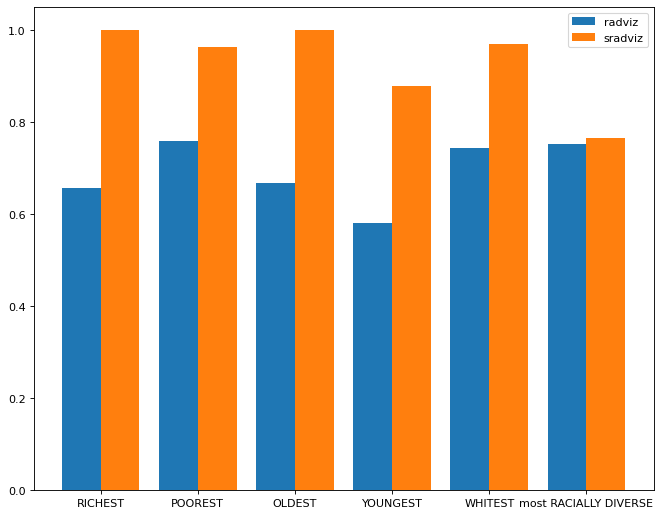

In [7]:
# Import Library

import numpy as np 
import matplotlib.pyplot as plt


# Define Data
quest = list(map(lambda x: x["q"], questions))
x_axis = np.arange(len(quest))
offset = -0.2

# Add size
plt.figure(figsize=(10, 8), dpi=80)

for state in metadata.keys():

    responses = pd.read_csv(metadata[state]["responces"])

    g_data = apply_func(responses, get_accuracy, state)[list(map(lambda x: x["q"], questions))].mean(axis=0).values

    # Multi bar Chart
    plt.bar(x_axis + offset, g_data, width=0.4, label = metadata[state]['graph'])
    offset += 0.4
    
# Xticks
lebels = []
for q in quest:
    start = 9
    end = q.index("(") - len("county  ")
    lebels.append(q[start:end])
plt.xticks(x_axis, lebels)

# Add legend
plt.legend()

# Display
plt.show()